## Setup

In [1]:
import pickle as pic
import numpy as np
import matplotlib.pyplot as plt
import json
import pprint
import sys

sys.path.append('../')
from nj_iwhd import IWHD

# Base parameters, no fitness
in_folder = "/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/trees/exponential_plus_c/400cells/no_fit/char40/"

In [20]:
# Load config
with open("config.json") as f:
    config = json.load(f)

# IO Setup
in_tree_raw = config["tree_dir"]

# Options:
pprint.pprint(config)

{'fitness_regimes': ['no_fit'],
 'mutation_proportions': [0.01, 0.1, 0.5, 0.6, 0.7],
 'num_trees': 50,
 'numcassettes': [10, 20, 40, 100],
 'numcells': 400,
 'numstates': [1, 10, 50, 100],
 'seed_dir': '/home/eecs/ivalexander13/datadir/simulation_data/seeds/',
 'top_dir': '/home/eecs/ivalexander13/datadir/simulation_data/topologies/{topology}/{fitness_regime}/cells{numcells}/',
 'topologies': ['exponential_plus_c'],
 'tree_dir': '/home/eecs/ivalexander13/datadir/simulation_data/trees3/mutrate{mutation_proportions}/char{numcassettes}/states{numstates}/exponential_plus_c/time1/no_fit/'}


In [21]:
# Helper getter
def get_pair(in_tree_raw, numtrees, **kwargs):
    if type(numtrees) is int:
        numtrees = [numtrees]
    
    dists_out = np.array([])
    dissim_out = np.array([])
    for numtree in numtrees:
        filename = in_tree_raw.format(**kwargs)

        dists = pic.load(open(filename + f'dists{numtree}.pkl', 'rb'))
        dissim = pic.load(open(filename + f'dissim_whd{numtree}.pkl', 'rb'))

        dists_out = np.append(dists_out, dists)
        dissim_out = np.append(dissim_out, dissim)

    return dists_out, dissim_out

get_pair(
    in_tree_raw, 
    numtrees=4,
    mutation_proportions=0.1, 
    numcassettes=20,
    numstates=1,
    numcells=400,)

(array([1.85436247, 1.85436247, 1.32459197, ..., 1.85436247, 1.85436247,
        1.16837498]),
 array([0.15, 0.1 , 0.1 , ..., 0.1 , 0.15, 0.05]))

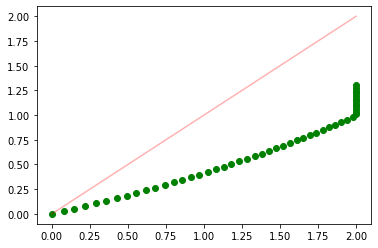

In [37]:
def whd2iwhd(whds, mutation_proportions, numstates, time=1):
    # state_distribution = pic.load(open(f"/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/priors/states{numstates}.pkl", "rb"))
    state_distribution = dict(enumerate([1 / numstates] * numstates, 1))

    iwhd = IWHD(
        state_distribution=state_distribution,
        mut_prop=mutation_proportions,
        total_time=time
    )
    
    return [2 * iwhd._iwhd(
        mut_rate=iwhd.mut_rate,
        collision_rate=iwhd.q,
        whd=whd,
        time=iwhd.total_time,
        error_tolerance=0.001,
    ) for whd in whds]

whds = np.linspace(0, 1.3, 50)
iwhds = whd2iwhd(whds, 0.5, 100, time=1)
plt.scatter(iwhds, whds, c='green')
linx = np.linspace(0, 2)
plt.plot(linx, linx, 'red', alpha=0.3)
plt.show()

In [38]:
def plot_pair(title, axx, numtrees, 
        mutation_proportions, 
        numcassettes,
        numstates,
        alpha=0.005
        ):
    # Get Pair of Arrays
    dists, dissim = get_pair(
        in_tree_raw, 
        numtrees=numtrees,
        mutation_proportions=mutation_proportions, 
        numcassettes=numcassettes,
        numstates=numstates,
        numcells=config['numcells']
        )

    # Calculate Correlation
    corr = np.round(np.corrcoef(dissim, dists)[0, 1], 3)

    # Calc MSE
    mse = np.round((np.square(dists - dissim)).mean(axis=None), 3)

    # Scatter Plot
    axx.scatter(x=dists, y=dissim, alpha=alpha)
    axx.set_title(f'{title}', fontweight="bold")
    axx.set(xlabel='True Distance', ylabel='WHD')
    linx = np.linspace(0, max(*dists, *dissim))
    liny = np.linspace(0, max(*dists, *dissim)/2)
    axx.plot(linx, liny, 'red', alpha=0.3)
    axx.text(0.05, 1.7, f"Corr {corr}\nMSE {mse}")
    try:
        whds = np.linspace(0, 1.3, 50)
        iwhds = whd2iwhd(
            whds, 
            mutation_proportions, 
            numstates, 
            time=1)

        axx.plot(iwhds, whds, c='green')
        axx.set_xlim(0, 2)
        axx.set_ylim(0, 2)
    except:
        pass
    # axx.show()
    # axx.clf()


In [43]:
def plot_diffs(title, axx, numtrees, 
        mutation_proportions, 
        numcassettes,
        numstates
        ):
    # Get Pair of Arrays
    dists, dissim = get_pair(
        in_tree_raw, 
        numtrees=numtrees,
        mutation_proportions=mutation_proportions, 
        numcassettes=numcassettes,
        numstates=numstates)

    iwhds = np.array(whd2iwhd(
        dissim, 
        mutation_proportions, 
        numstates, 
        time=1
        ))

    # Calculate Correlation
    corr = np.round(np.corrcoef(dissim, dists)[0, 1], 3)

    # Calc MSE
    mse = np.round((np.square(dists - dissim)).mean(axis=None), 3)

    # Sort for plot
    sorted_idx = dists.argsort()
    
    # Scatter Plot
    x = range(len(dists))
    axx.scatter(x, dists[sorted_idx], alpha=0.005, c='blue', label='True Distance')
    axx.scatter(x, dissim[sorted_idx], alpha=0.005, c='red', label='WHD')
    axx.scatter(x, iwhds[sorted_idx], alpha=0.005, c='green', label='iWHD')
    
    axx.set_title(f'{title}', fontweight="bold")
    axx.set(xlabel='Leaves', ylabel='Distance')


# Mutation Proportion

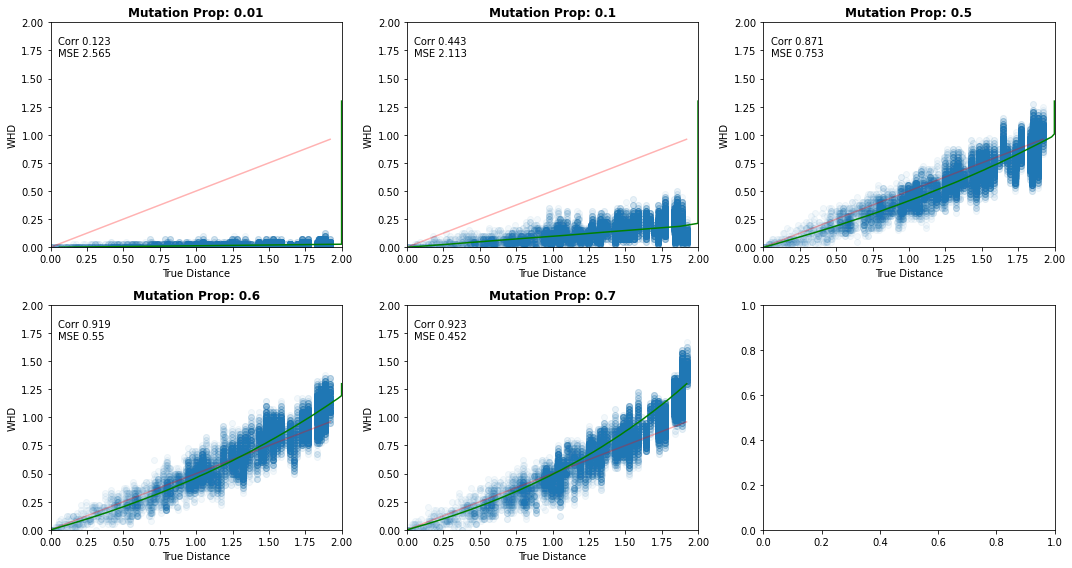

<Figure size 432x288 with 0 Axes>

In [39]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in zip(config['mutation_proportions'], axs.flat):
    plot_pair(
        title=f'Mutation Prop: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=i, 
        numcassettes=40,
        numstates=100,
        alpha=0.05
        )

plt.tight_layout()
plt.show()
plt.clf();

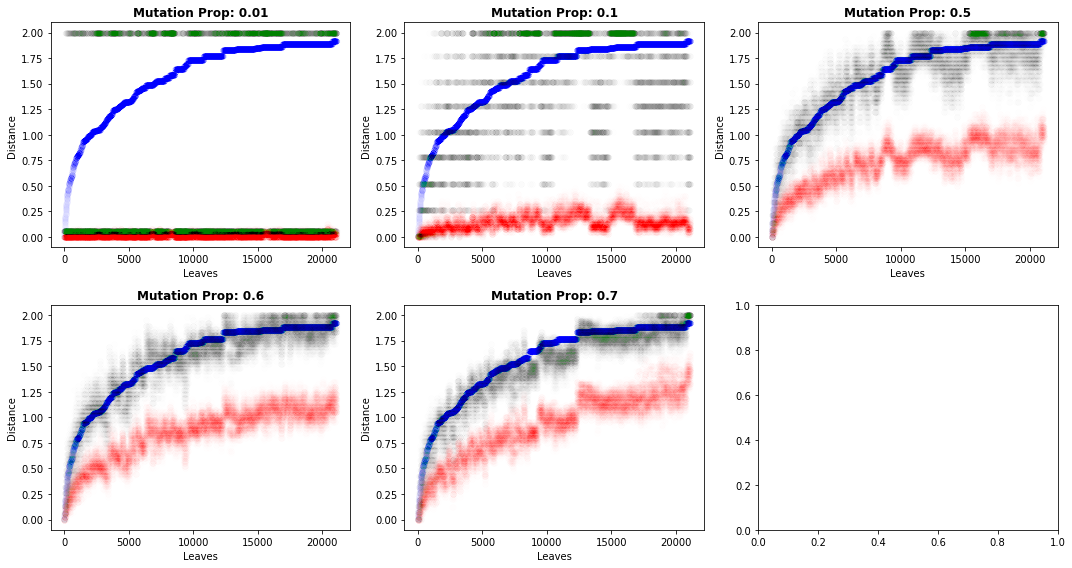

<Figure size 432x288 with 0 Axes>

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in zip(config['mutation_proportions'], axs.flat):
    plot_diffs(
        title=f'Mutation Prop: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=i, 
        numcassettes=40,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf()

## Comparing NumCassettes


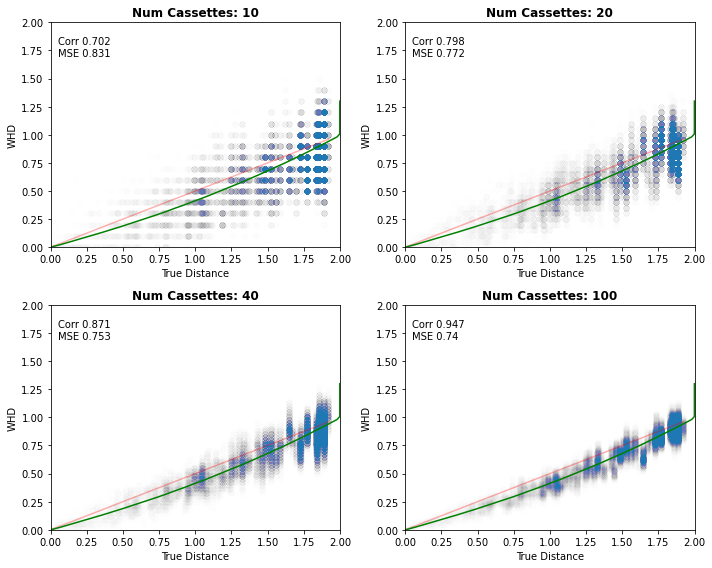

<Figure size 432x288 with 0 Axes>

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numcassettes'], axs.flat):
    plot_pair(
        title=f'Num Cassettes: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=i,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf()

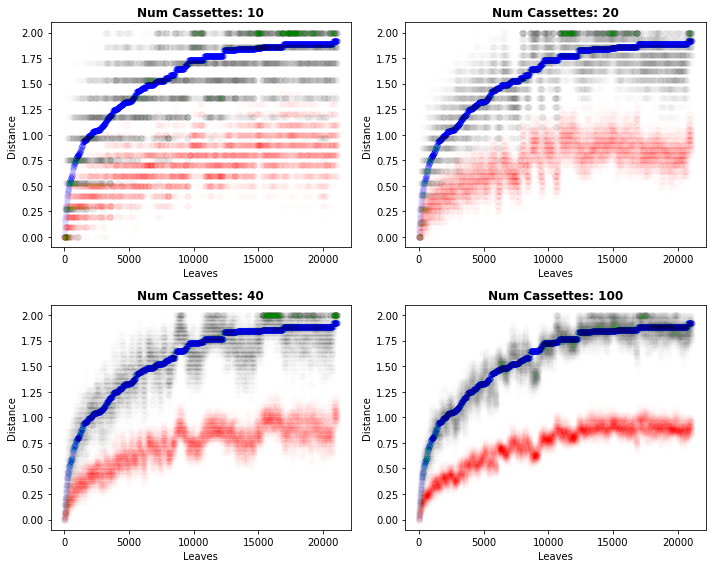

<Figure size 432x288 with 0 Axes>

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numcassettes'], axs.flat):
    plot_diffs(
        title=f'Num Cassettes: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=i,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf()

## Across NumStates

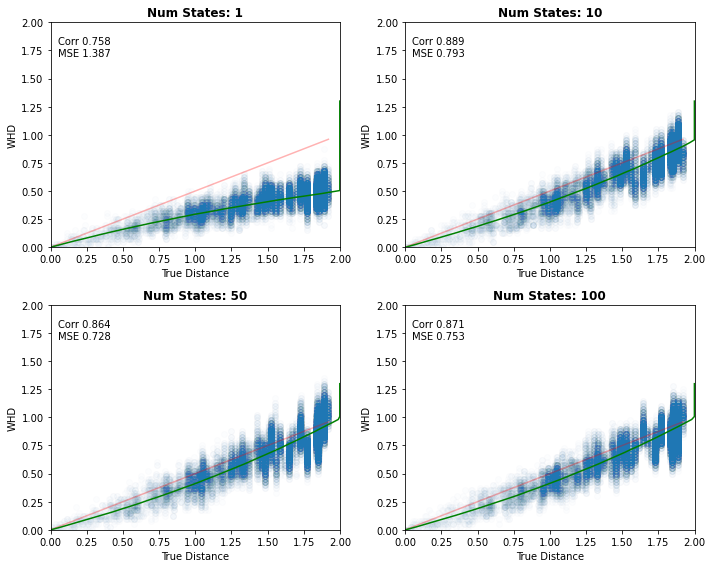

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numstates'], axs.flat):
    plot_pair(
        title=f'Num States: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=40,
        numstates=i)

plt.tight_layout()
plt.show()
plt.clf()

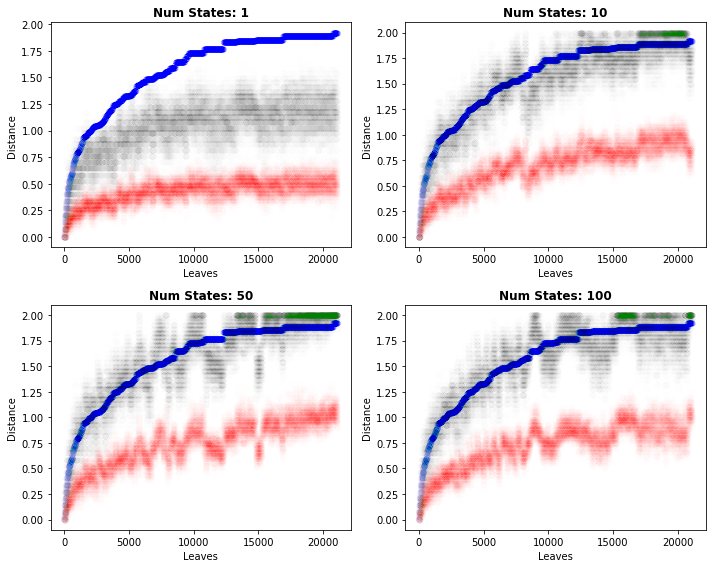

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numstates'], axs.flat):
    plot_diffs(
        title=f'Num States: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=40,
        numstates=i)

plt.tight_layout()
plt.show()
plt.clf()